This will demonstrate how to achieve a constant concentration $[S]_\mathrm{eq}$ of S particles, where the value of $[S]_\mathrm{eq}$ can be roughly adjusted under some approximations. In [4] we use such a mechanism to construct a spherical shell in which a constant concentration is maintained.

Define reactions of substrate with factory particles F

$$F \rightleftharpoons F + S$$ 

with forward propensity (intrinsic rate constant) $f_+$ and backward propensity $f_-$. The according macroscopic rates of these processes would be $k_+$ and $k_-$. In equilibrium under assumption of the law of mass action [1]:

$$
K = \frac{[F]_\mathrm{eq}[S]_\mathrm{eq}}{[F]_\mathrm{eq}} = [S]_\mathrm{eq}
$$

The equilibrium constant also relates $k_+$ and $k_-$, which are functions of the propensities $f_+$ and $f_-$ respectively:

$$
K = \frac{k_+(f_+)}{k_-(f_-)}
$$

Since the "$+$" reaction is unimolecular we have $k_+=f_+$. The "$-$" reaction depends on encounter of F and S. With no potentials between F and S one can use Doi's formula [2, 3] for $k_-$

$$
k_-= 4\pi D R \left(1-\frac{\tanh(\kappa R)}{\kappa R}\right)
$$

where $\kappa=\sqrt{f_- / D}$ is an inverse penetration depth (proportional to the speed of the reaction), $D=D_F + D_S$ the relative diffusion coefficient and $R$ is the reaction radius. The expressions for $k_+$ and $k_-$ are only expected to work in the absence of re-binding and multibody effects. Additionally the law of mass action assumes all reactants to be in contact with one another. Both requirements are fulfilled if the reaction process is be in the well-mixed (reaction-limited) regime. This corresponds to $\kappa R \ll 1$.

Combining the equations above gives the constant concentration

$$
[S]_\mathrm{eq} = \frac{f_+}{4\pi DR\left(1-\frac{\tanh(R\sqrt{f_-/D})}{R\sqrt{f_-/D}}\right)}
$$

Choosing
- $\kappa R = 0.1$ (rather well-mixed)
- $D_F = D_S = 1 ~[\mathrm{length}]^2 [\mathrm{time}]^{-1}$ gives $D=1 ~[\mathrm{length}]^2 [\mathrm{time}]^{-1}$
- $R=0.5 ~[\mathrm{length}]$

gives $f_- = \kappa R D / R^2 = 0.08 ~ [\mathrm{time}]^{-1}$ as backward propensity and

$$
[S]_\mathrm{eq} = \frac{f_+}{0.041721} [\mathrm{length}]^{-3}[\mathrm{time}]^{1}
$$

as the value for the constant concentration, where $f_+$ remains as a "control knob". $[\mathrm{length}]$ and $[\mathrm{time}]$ are the units of length and time.

- [1] Atkins, Peter; de Paula, Julio: Atkins’ physical chemistry, Oxford University Press, 2006 
- [2] Doi, Masao: Theory of diffusion-controlled reactions between non-simple molecules. I , Chemical Physics ll, 107–113, 1975
- [3] Erban, Radek; Chapman, Jonathan: Stochastic modelling of reaction-diffusion processes: algorithms for bimolecular reactions. , Physical biology 6(4), 046001, jan 2009
- [4] Dibak, Manuel; Fröhner, Christoph; Noé, Frank; Höfling, Felix: Diffusion-influenced reaction rates in the presence of pair interactions. (_in prep_)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import readdy

In [2]:
readdy.__version__

'v2.0.1-54'

In [3]:
def equ_concentration(forward_propensity):
    return forward_propensity / 0.041721

factory_minus_rate = 0.08
factory_plus_rate = 0.1
factory_reaction_radius = 0.5
concentration = equ_concentration(factory_plus_rate)

In [4]:
system = readdy.ReactionDiffusionSystem(
    box_size=[10.,10.,10.], 
    periodic_boundary_conditions=[True, True, True],
    unit_system=None
)

system.add_species("S", 1.)
system.add_species("F", 1.)

system.reactions.add_fusion(
    "factory-fusion", "F", "S", "F", factory_minus_rate,
    factory_reaction_radius, weight1=0., weight2=1.)
system.reactions.add_fission(
    "factory-fission", "F", "F", "S", factory_plus_rate,
    factory_reaction_radius, weight1=0., weight2=1.)

In [5]:
simulation = system.simulation("SingleCPU", reaction_handler="UncontrolledApproximation")
simulation.observe.number_of_particles(1, types=["S", "F"])
simulation.output_file = "const_concentration.h5"
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

simulation.add_particles("F", np.random.uniform(size=(1000,3)) * 10. - 5.)

timestep = 5e-3
simulation.run(50000, timestep)

Configured kernel context with:
--------------------------------
 - kBT = 1
 - periodic b.c. = (true, true, true)
 - box size = (10, 10, 10)
 - particle types:
     *  particle type "F" with D=1
     *  particle type "S" with D=1
 - unimolecular reactions:
     * Fission F -> F + S with a rate of 0.1, a product distance of 0.5, and weights 0 and 1
 - bimolecular reactions:
     * Fusion F + S -> F with a rate of 0.08, an educt distance of 0.5, and weights 0 and 1

Configured simulation loop with:
--------------------------------
 - timeStep = 0.005
 - evaluateObservables = true
 - progressOutputStride = 10
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true 
   * Update neighbor list? true 
   * Clear neighbor list? true 
   * Integrate diffusion? true 
   * Calculate forces? true 
   * Handle reactions? true 
   * Handle topology reactions? true 

[2019-05-06 15:22:56] [info] Simulation completed


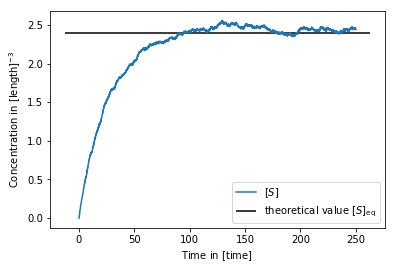

In [7]:
traj = readdy.Trajectory(simulation.output_file)
time, counts = traj.read_observable_number_of_particles()

volume = 10**3
plt.plot(time * timestep, counts[:,0]/volume, label=r"$[S]$")
plt.hlines(concentration, *plt.xlim(), label=r"theoretical value $[S]_\mathrm{eq}$")
plt.legend(loc="lower right")
plt.xlabel(r"Time in $[\mathrm{time}]$")
plt.ylabel(r"Concentration in $[\mathrm{length}]^{-3}$")
plt.show()